In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from copy import deepcopy
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
from sklearn.feature_selection import mutual_info_regression
from scipy import stats

# Insert the parent directory to the path to be able to see the robustDA module
import sys
sys.path.append('..')

from robustDA import process_cmip6, processing, anchor_regression, plots, plots_small, hypothesis_testing, utils
from robustDA.processing import split_train_test, split_folds_CV
from robustDA.process_cmip6 import read_forcing_cmip6
from robustDA.plots_small import plotMapCartopy, plotMapCartopy_subplots

%reload_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
params_climate = {
        "temporalRes": "ann",
        "variables": ["tas"],
        "scenarios": ["historical", "piControl"],
        "startDate": 1850,
        "endDate": 2014,
        "target": "GHG",
        "anchor": "aerosols",
    }

params_anchor = {
        "gamma": [1],
        "h_anchors":['square'],
    }

In [3]:
target = params_climate["target"]
anchor = params_climate["anchor"]
startDate = params_climate["startDate"]
endDate = params_climate["endDate"]

gamma = params_anchor["gamma"]
h_anchors = params_anchor["h_anchors"]

In [4]:
modelsDataList, modelsInfoFrame = process_cmip6.read_files_cmip6(params_climate)

# modelsInfoFrame.head()

In [5]:
#pd.set_option('display.max_rows', 100)
modelsInfoFrame.to_csv('models.csv')
modelsInfoFrame

,filename,var,temporalRes,modelFull,model,scenario,spatialRes
0,tas_ann_ACCESS-CM2_historical_r1i1p1f1_g025.nc,tas,ann,ACCESS-CM2,ACC,historical,g025
1,tas_ann_ACCESS-CM2_piControl_r1i1p1f1_g025.nc,tas,ann,ACCESS-CM2,ACC,piControl,g025
2,tas_ann_ACCESS-ESM1-5_historical_r1i1p1f1_g025.nc,tas,ann,ACCESS-ESM1-5,ACC,historical,g025
3,tas_ann_ACCESS-ESM1-5_piControl_r1i1p1f1_g025.nc,tas,ann,ACCESS-ESM1-5,ACC,piControl,g025
4,tas_ann_AWI-CM-1-1-MR_historical_r1i1p1f1_g025.nc,tas,ann,AWI-CM-1-1-MR,AWI,historical,g025
...,...,...,...,...,...,...,...
109,tas_ann_NorESM2-MM_piControl_r1i1p1f1_g025.nc,tas,ann,NorESM2-MM,Nor,piControl,g025
110,tas_ann_SAM0-UNICON_historical_r1i1p1f1_g025.nc,tas,ann,SAM0-UNICON,SAM,historical,g025
111,tas_ann_SAM0-UNICON_piControl_r1i1p1f1_g025.nc,tas,ann,SAM0-UNICON,SAM,piControl,g025
112,tas_ann_TaiESM1_historical_r1i1p1f1_g025.nc,tas,ann,TaiESM1,Tai,historical,g025


In [6]:
sum(modelsInfoFrame['scenario'] == 'piControl')

55

In [138]:
dir = '/net/ch4/data/cmip6-Next_Generation/tas/ann/g025/'

list_files = modelsInfoFrame['filename']
list_files = list(list_files)
list_files = [f'{dir}{elem}' for elem in list_files]
list_files = pd.Series(list_files)
list_files.to_csv('list_files.txt', header=False, index=False)
list_files

0      /net/ch4/data/cmip6-Next_Generation/tas/ann/g0...
1      /net/ch4/data/cmip6-Next_Generation/tas/ann/g0...
2      /net/ch4/data/cmip6-Next_Generation/tas/ann/g0...
3      /net/ch4/data/cmip6-Next_Generation/tas/ann/g0...
4      /net/ch4/data/cmip6-Next_Generation/tas/ann/g0...
                             ...                        
109    /net/ch4/data/cmip6-Next_Generation/tas/ann/g0...
110    /net/ch4/data/cmip6-Next_Generation/tas/ann/g0...
111    /net/ch4/data/cmip6-Next_Generation/tas/ann/g0...
112    /net/ch4/data/cmip6-Next_Generation/tas/ann/g0...
113    /net/ch4/data/cmip6-Next_Generation/tas/ann/g0...
Length: 114, dtype: object

In [137]:
len(np.unique(modelsInfoFrame["model"]))

28

In [6]:
import pickle
# filename = ("./../output/data/HT_GHG_aerosols_square_B50_CV3_spearman95_coefRaw_valPA_lsqr.pkl")
filename = ("./../output/data/HT_aerosols_co2_square_B50_CV3_spearman95_coefRaw_valPA_lsqr.pkl")

# filename = ("./../output/data/HT_aerosols_co2_square_B50_CV3_spearman95_coefRaw_valPA_lsqr.pkl")

with open(filename, 'rb') as f:
    params_climate, params_anchor, lambda_vals, y_train_true, y_anchor_train, y_test_true, y_anchor_test, \
        ind_gamma_opt_lin, ind_lambda_opt_lin, ind_lambda_opt_ridge_lin, gamma_opt_lin, lambda_opt_lin, lambda_opt_ridge_lin, \
        ind_vect_ideal_obj1_lin, ind_vect_ideal_obj2_lin, \
        coef_raw_opt_lin, coef_raw_opt_ridge_lin, \
        y_train_pred_lin, y_train_pred_ridge_lin, \
        y_test_pred_lin, y_test_pred_ridge_lin, \
        rmse_train_lin, rmse_PA_train_lin, corr_train_lin, mi_train_lin, rmse_test_lin, rmse_PA_test_lin, corr_test_lin, mi_test_lin, \
        alpha_bagging_lin, power_bagging_lin, \
        ind_gamma_opt_nonlin, ind_lambda_opt_nonlin, ind_lambda_opt_ridge_nonlin, gamma_opt_nonlin, lambda_opt_nonlin, lambda_opt_ridge_nonlin, \
        ind_vect_ideal_obj1_nonlin, ind_vect_ideal_obj2_nonlin, \
        coef_raw_opt_nonlin, coef_raw_opt_ridge_nonlin, \
        y_train_pred_nonlin, y_train_pred_ridge_nonlin, \
        y_test_pred_nonlin, y_test_pred_ridge_nonlin, \
        rmse_train_nonlin, rmse_PA_train_nonlin, corr_train_nonlin, corr2_train_nonlin, mi_train_nonlin, \
        rmse_test_nonlin, rmse_PA_test_nonlin, corr_test_nonlin, corr2_test_nonlin, mi_test_nonlin, \
        alpha_bagging_nonlin, power_bagging_nonlin, \
        nb_models_bagging, models, modelsInfoFrame = pickle.load(f)
    
# params = filename.split("_")
target = params_climate["target"]
anchor = params_climate["anchor"]
gamma_vals = params_anchor["gamma"]
h_anchors = params_anchor["h_anchors"]

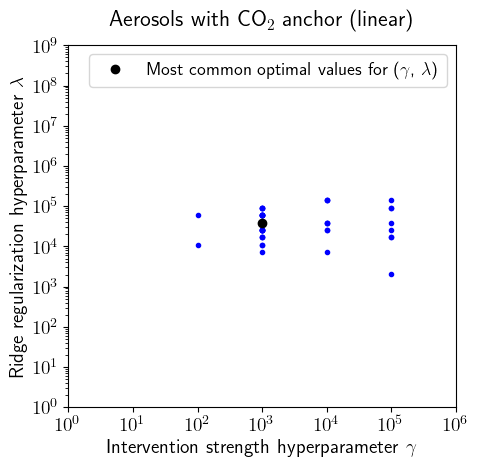

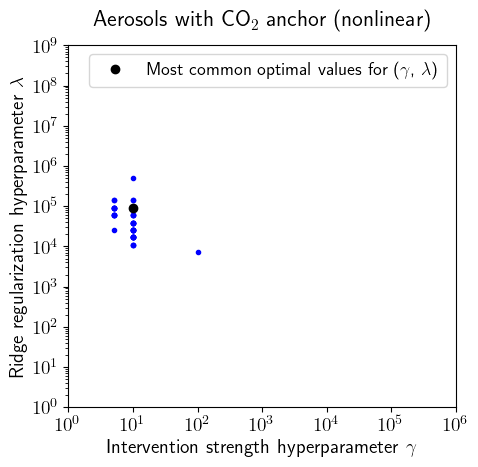

In [113]:
# title = "GHG with aerosols anchor (linear)"
# filename = "GHG_aerosols_lin_optimal_pair.pdf"
# plots_small.plot_optimal_hyperparameters(gamma_opt_lin, lambda_opt_lin, title, filename)

# title = "GHG with aerosols anchor (nonlinear)"
# filename = "GHG_aerosols_nonlin_optimal_pair.pdf"
# plots_small.plot_optimal_hyperparameters(gamma_opt_nonlin, lambda_opt_nonlin, title, filename)

title = "Aerosols with CO$_2$ anchor (linear)"
filename = "aerosols_co2_lin_optimal_pair.pdf"
plots_small.plot_optimal_hyperparameters(gamma_opt_lin, lambda_opt_lin, title, filename)

title = "Aerosols with CO$_2$ anchor (nonlinear)"
filename = "aerosols_co2_nonlin_optimal_pair.pdf"
plots_small.plot_optimal_hyperparameters(gamma_opt_nonlin, lambda_opt_nonlin, title, filename)

In [60]:
from statistics import mode
int(mode(list(gamma_opt_nonlin.reshape(-1))))

10

In [8]:
alpha_bagging_nonlin

array([0.21428571, 0.        , 0.        , 0.        , 0.        ,
       0.07692308, 0.        , 0.        , 0.        , 0.14166667,
       0.03636364, 0.        , 0.        , 0.        , 0.31481481,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.04      , 0.        , 0.03703704,
       0.25      , 0.04347826, 0.        ])

In [301]:
sum(alpha_bagging_nonlin == 0)

21

In [269]:
np.max(alpha_bagging_nonlin)

0.5416666666666666

In [200]:
list(alpha_bagging_lin).index(0.1625)

ValueError: 0.1625 is not in list

In [278]:
models[22]

'MPI'

In [9]:
models

['ACC',
 'AWI',
 'BCC',
 'CAM',
 'CAS',
 'CES',
 'CIE',
 'CMC',
 'Can',
 'E3S',
 'EC-',
 'FGO',
 'FIO',
 'GFD',
 'GIS',
 'ICO',
 'IIT',
 'INM',
 'IPS',
 'KIO',
 'MCM',
 'MIR',
 'MPI',
 'MRI',
 'NES',
 'Nor',
 'SAM',
 'Tai']

In [262]:
power_bagging_nonlin

array([1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 0.66666667, 1.        , 1.        ,
       0.96923077, 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        ])

In [265]:
sum(power_bagging_nonlin == 1)

26

In [302]:
unique, counts = np.unique(gamma_opt_lin, return_counts=True)
print(unique)
print(counts)

[  100.  1000. 10000.]
[ 7 30 13]


In [296]:
y_test_true[0][0].shape

(8745, 1)

In [235]:
sum(gamma_opt_lin == 1000)

array([31])

In [238]:
sum(gamma_opt_lin == 100)

array([2])

In [239]:
sum(gamma_opt_lin == 10000)

array([9])

In [243]:
sum(gamma_opt_lin == 100000)

array([8])

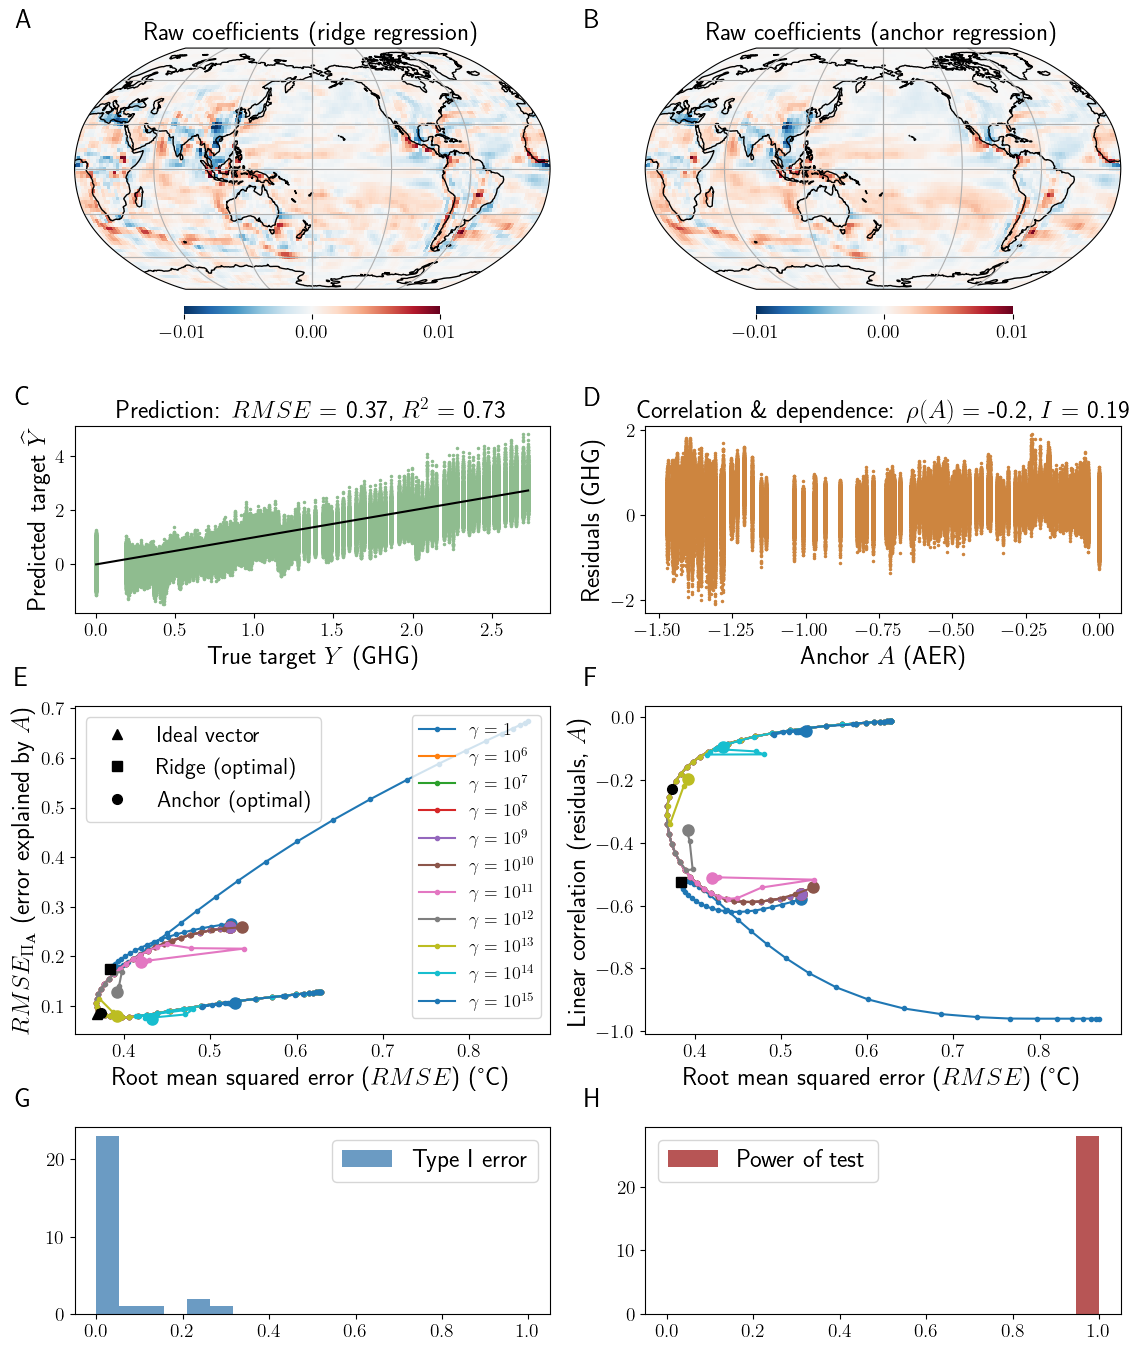

In [7]:
plots_small.plot_all_v2(
    np.mean(coef_raw_opt_lin, axis = 0), 
    np.mean(coef_raw_opt_ridge_lin, axis = 0), 
    y_test_true, 
    y_test_pred_lin, 
    y_test_pred_ridge_lin, 
    y_anchor_test,
    target, 
    anchor, 
    [],
    rmse_train_lin,
    rmse_PA_train_lin,
    corr_train_lin,
    mi_train_lin,
    gamma_vals,
    lambda_vals,
    ind_gamma_opt_lin,
    ind_lambda_opt_lin,
    ind_lambda_opt_ridge_lin,
    ind_vect_ideal_obj1_lin, 
    ind_vect_ideal_obj2_lin,
    alpha_bagging_lin,
    power_bagging_lin,
    formatFig = "pdf",
    # filename="GHG_aer_lin_largeGamma.pdf",
)

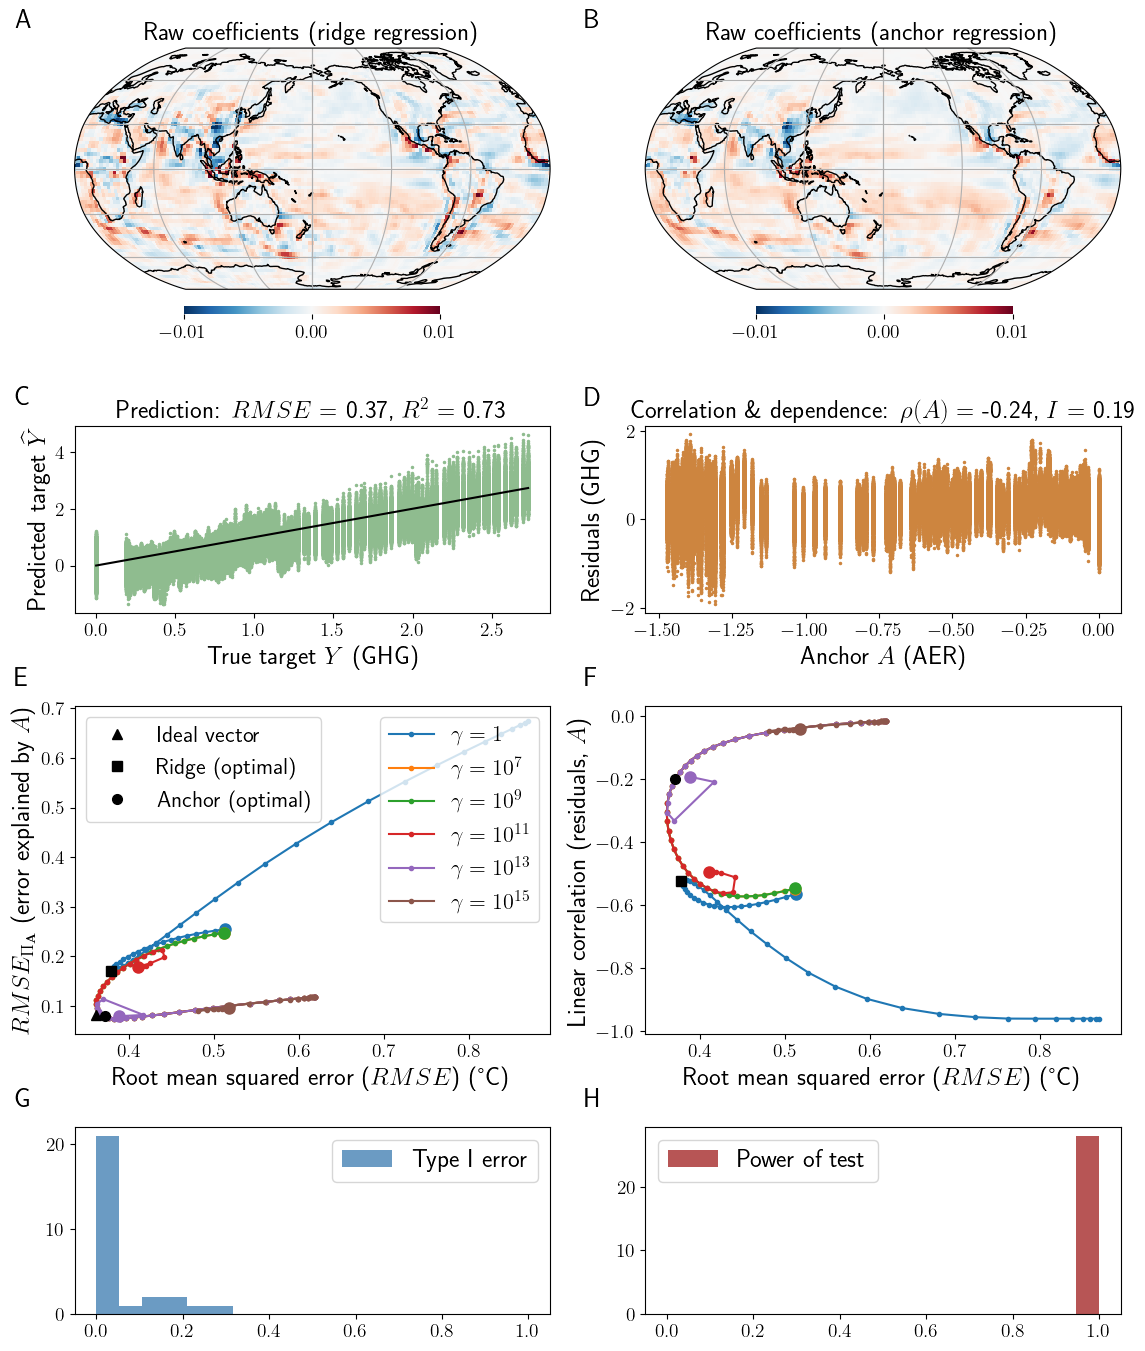

In [288]:
plots_small.plot_all_v2(
    np.mean(coef_raw_opt_nonlin, axis = 0), 
    np.mean(coef_raw_opt_ridge_nonlin, axis = 0), 
    y_test_true, 
    y_test_pred_nonlin, 
    y_test_pred_ridge_nonlin, 
    y_anchor_test,
    target, 
    anchor, 
    h_anchors,
    rmse_train_nonlin,
    rmse_PA_train_nonlin,
    corr_train_nonlin,
    mi_train_nonlin,
    gamma_vals,
    lambda_vals,
    ind_gamma_opt_nonlin,
    ind_lambda_opt_nonlin,
    ind_lambda_opt_ridge_nonlin,
    ind_vect_ideal_obj1_nonlin, 
    ind_vect_ideal_obj2_nonlin,
    alpha_bagging_nonlin,
    power_bagging_nonlin,
    formatFig = "pdf",
    #filename="GHG_aer_nonlin.pdf",
)

-0.18679999999999997


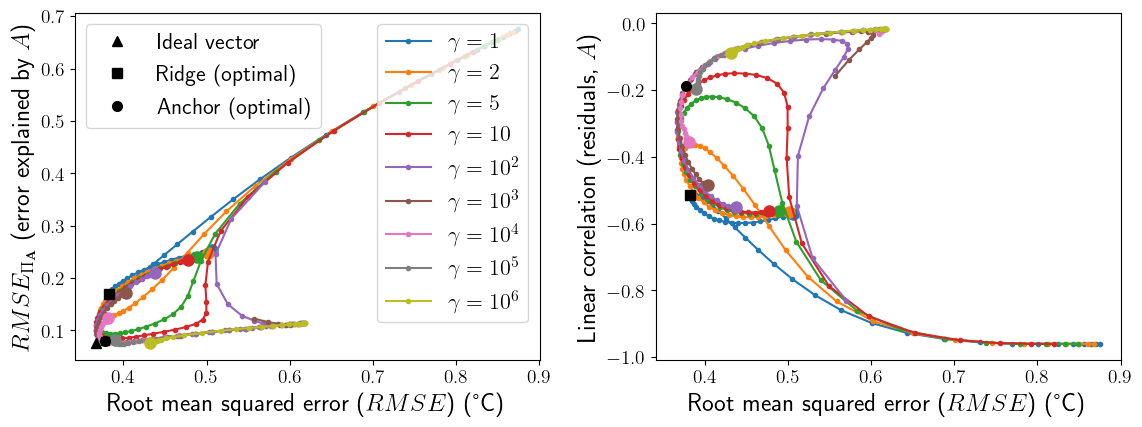

In [305]:
plots_small.plot_Pareto(
    rmse_train_lin,
    rmse_PA_train_lin,
    corr_train_lin,
    mi_train_lin,
    [],
    gamma_vals,
    lambda_vals,
    ind_gamma_opt_lin,
    ind_lambda_opt_lin,
    ind_lambda_opt_ridge_lin,
    ind_vect_ideal_obj1_lin, 
    ind_vect_ideal_obj2_lin,
    formatFig = "pdf",
    filename=None #"GHG_aer_hyperparameterOptim.png",
)

-0.2004


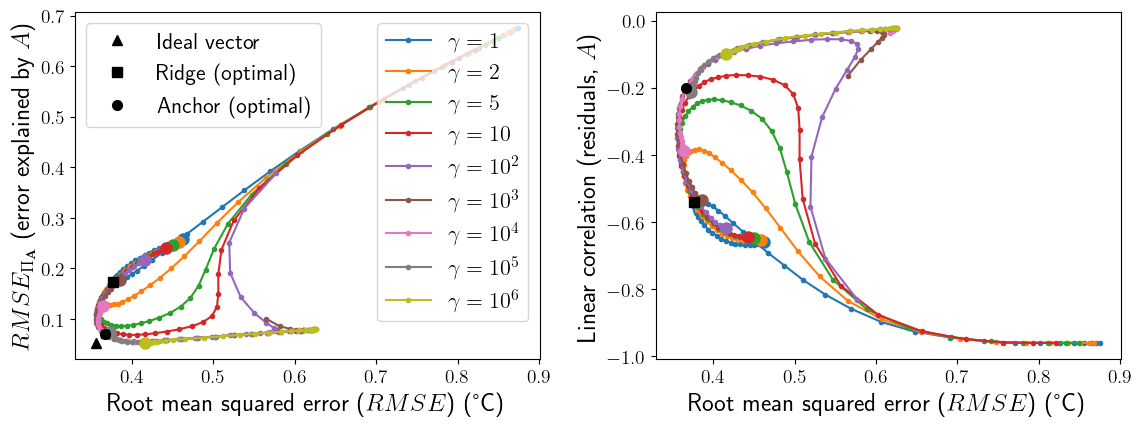

In [306]:
plots_small.plot_Pareto(
    rmse_test_lin,
    rmse_PA_test_lin,
    corr_test_lin,
    mi_test_lin,
    [],
    gamma_vals,
    lambda_vals,
    ind_gamma_opt_lin,
    ind_lambda_opt_lin,
    ind_lambda_opt_ridge_lin,
    ind_vect_ideal_obj1_lin, 
    ind_vect_ideal_obj2_lin,
    formatFig = "pdf",
    #filename="aer_co2_lin_test.pdf",
)

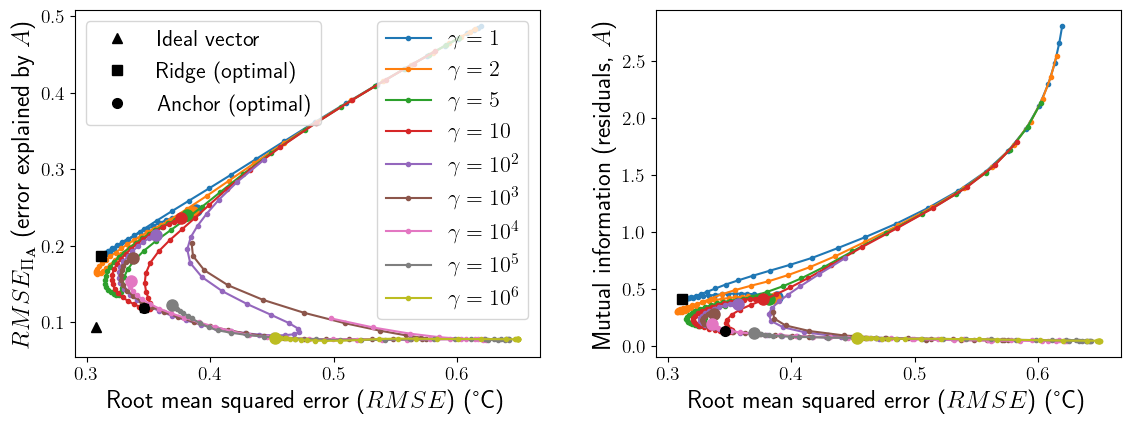

In [227]:
plots_small.plot_Pareto(
    rmse_test_nonlin,
    rmse_PA_test_nonlin,
    corr_test_nonlin,
    mi_test_nonlin,
    h_anchors,
    gamma_vals,
    lambda_vals,
    ind_gamma_opt_nonlin,
    ind_lambda_opt_nonlin,
    ind_lambda_opt_ridge_nonlin,
    ind_vect_ideal_obj1_nonlin, 
    ind_vect_ideal_obj2_nonlin,
    formatFig = "pdf",
    filename="aer_co2_nonlin_test.pdf",
)

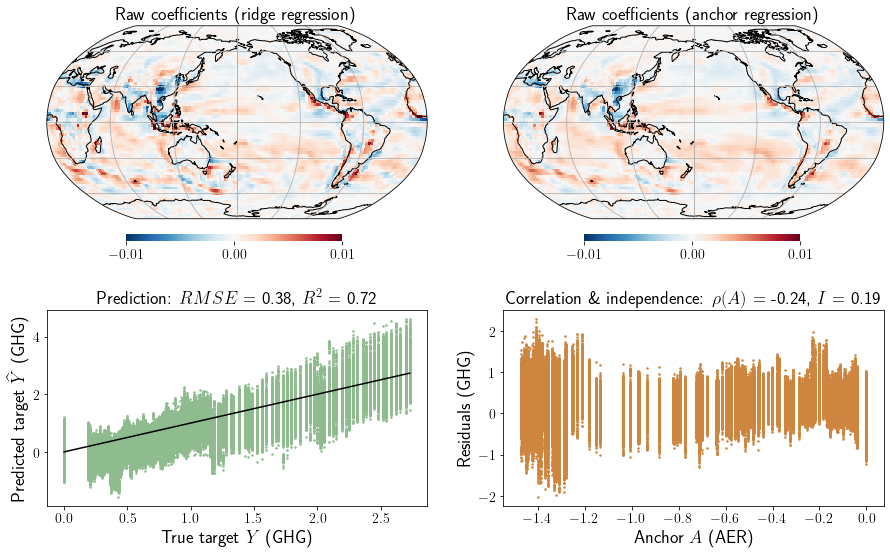

In [13]:
plots.plot_maps(
    np.mean(coef_raw_opt_lin, axis = 0), 
    np.mean(coef_raw_opt_ridge_lin, axis = 0), 
    y_test_true, 
    y_test_pred_lin, 
    y_test_pred_ridge_lin, 
    y_anchor_test,
    target, 
    anchor, 
    [],
    rmse_train_lin,
    rmse_PA_train_lin,
    corr_train_lin,
    mi_train_lin,
    gamma_vals,
    lambda_vals,
    ind_gamma_opt_lin,
    ind_lambda_opt_lin,
    ind_lambda_opt_ridge_lin,
    ind_vect_ideal_obj1_lin, 
    ind_vect_ideal_obj2_lin,
    filename=None #"GHG_aer_lin_maps.png",
)

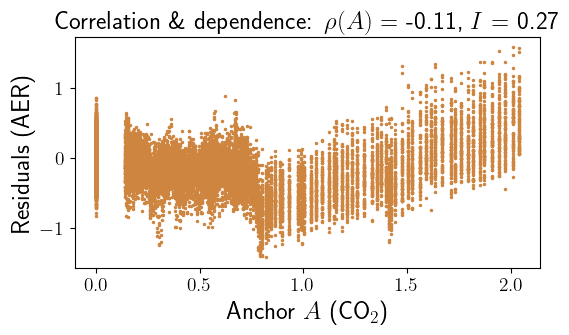

In [4]:
ax1

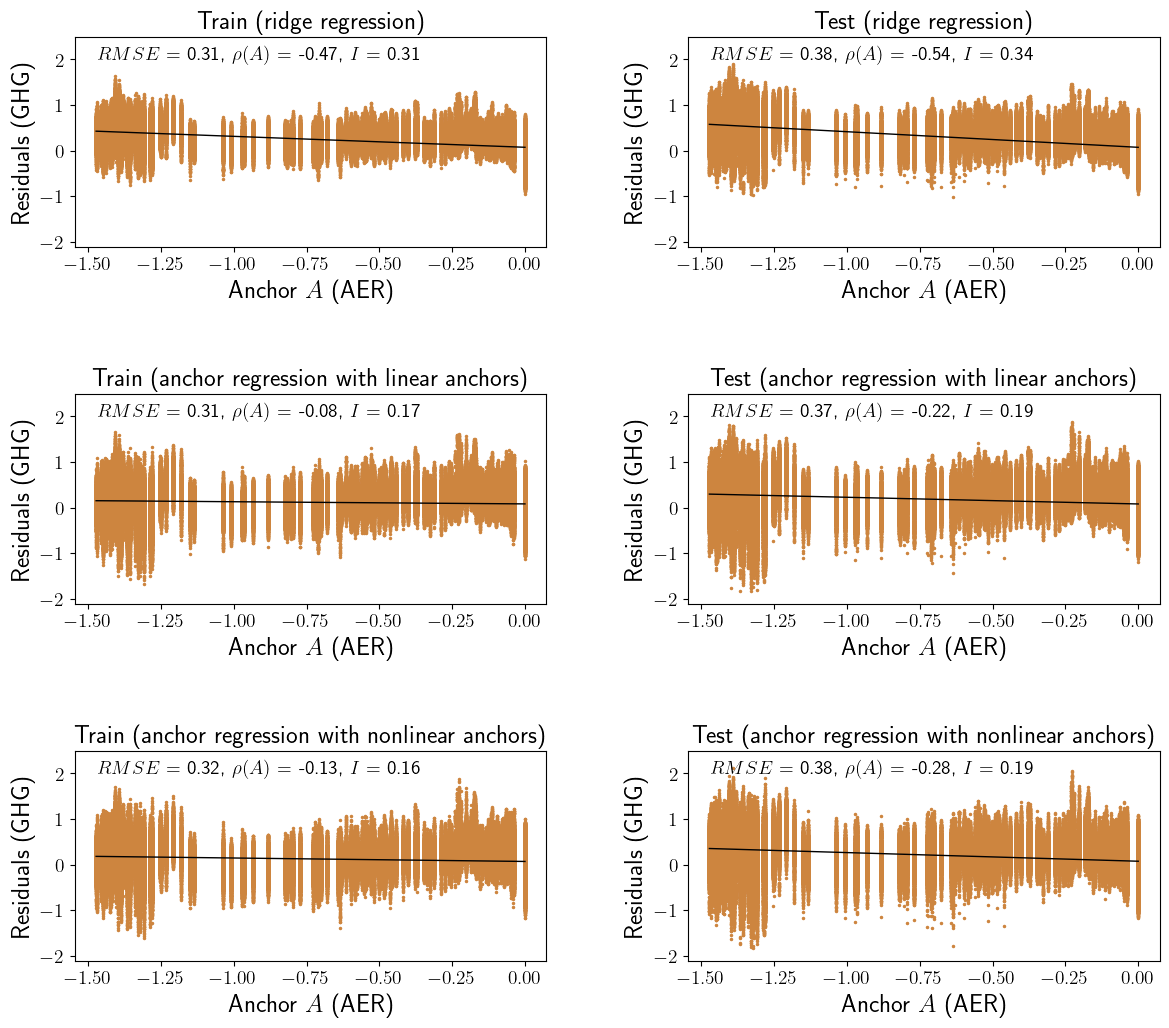

In [5]:
fig, ((ax11, ax12), (ax21, ax22), (ax31, ax32)) = plt.subplots(3, 2, figsize=(14, 12))

ax11 = plots_small.plot_residuals(
    y_train_true, y_train_pred_ridge_lin, y_anchor_train, target, anchor, [], ax11
)
ax11.set_title('Train (ridge regression)')

ax12 = plots_small.plot_residuals(
    y_test_true, y_test_pred_ridge_lin, y_anchor_test, target, anchor, [], ax12
)

ax12.set_title('Test (ridge regression)')

ax21 = plots_small.plot_residuals(
    y_train_true, y_train_pred_lin, y_anchor_train, target, anchor, [], ax21
)
ax21.set_title('Train (anchor regression with linear anchors)')

ax22 = plots_small.plot_residuals(
    y_test_true, y_test_pred_lin, y_anchor_test, target, anchor, [], ax22
)
ax22.set_title('Test (anchor regression with linear anchors)')

ax31 = plots_small.plot_residuals(
    y_train_true, y_train_pred_nonlin, y_anchor_train, target, anchor, [], ax31
)
ax31.set_title('Train (anchor regression with nonlinear anchors)')

ax32 = plots_small.plot_residuals(
    y_test_true, y_test_pred_nonlin, y_anchor_test, target, anchor, [], ax32
)

ax32.set_title('Test (anchor regression with nonlinear anchors)')

plt.subplots_adjust(wspace=0.3, hspace=0.7)

fig.savefig("./../output/figures/residuals_aer_co2.pdf", bbox_inches="tight")

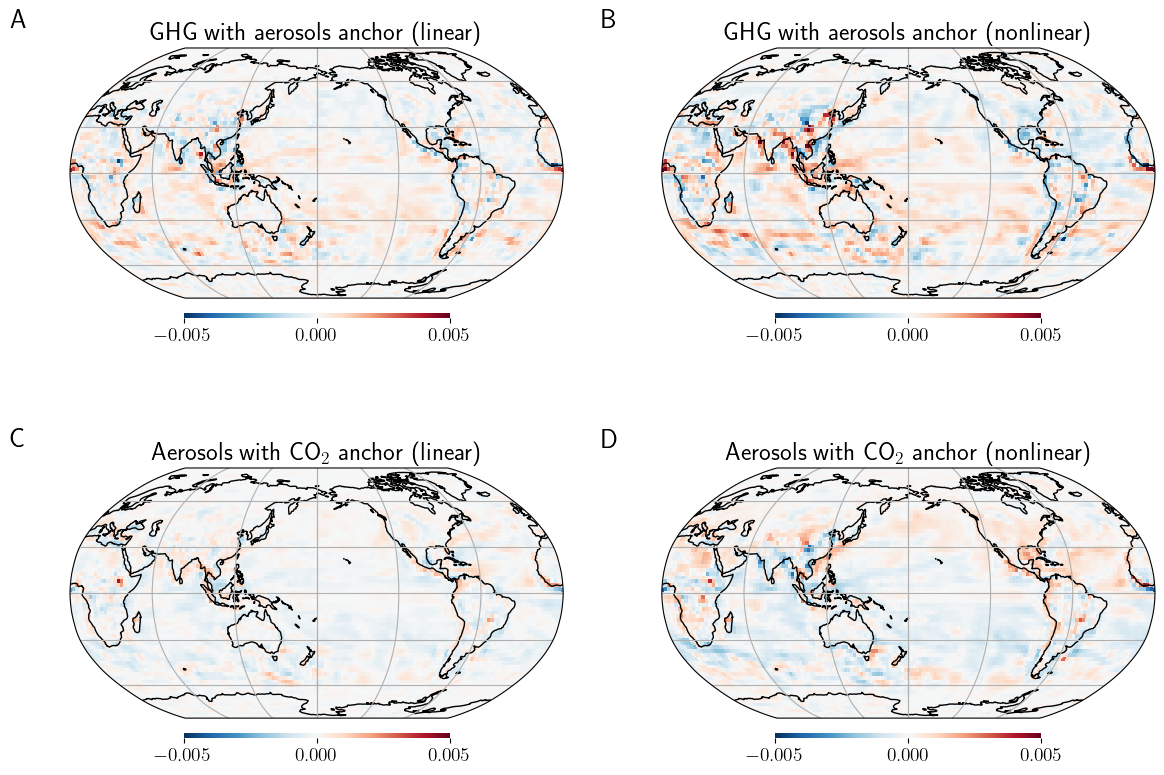

In [231]:
plots_small.plot_difference_maps("pdf", "coef_difference.pdf")